In [36]:
from itertools import product
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import sys
sys.path.append("../..")
from berp.datasets.eeg import load_eeg_dataset
from berp.viz.trf import plot_trf_coefficients

In [39]:
model_dir = "../../workflow/gillis2021/results_microaverage/GroNLP/gpt2-small-dutch/trf-berp-cannon.20221117.nested"
subjects = ["microaverage"]

dataset_dir = "../../workflow/gillis2021/data/dataset/GroNLP/gpt2-small-dutch/"
stimulus_dir = "../../workflow/gillis2021/data/stimulus/GroNLP/gpt2-small-dutch/"
stories = ["DKZ_1", "DKZ_2"]

In [40]:
# Load datasets.
target_sensors = ["C1", "Cz", "C2", "CP1", "CPz", "CP2"]
ds = {}
stimulus_paths = {story: Path(stimulus_dir) / f"{story}.pkl" for story in stories}
combs = list(product(stories, subjects))
for story, subject in tqdm(combs):
    ds_path = Path(dataset_dir) / story / f"{subject}.pkl"
    if not ds_path.exists():
        print(f"Could not find dataset {ds_path}")
        continue

    ds[story, subject] = load_eeg_dataset(
        [ds_path], subset_sensors=target_sensors,
        stimulus_paths=stimulus_paths,
        normalize_X_ts=True, normalize_X_variable=True, normalize_Y=True).datasets[0]

  0%|          | 0/2 [00:00<?, ?it/s]

In [41]:
sample_ds = next(iter(ds.values()))

In [42]:
sample_ds.variable_feature_names

['recognition_onset', 'word_frequency', 'word_surprisal']

In [43]:
# Load learned coefficients
coef_df = pd.concat([pd.read_csv(Path(model_dir) / "params" / f"encoder_coefs.{subject}.csv")
                     for subject in subjects])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


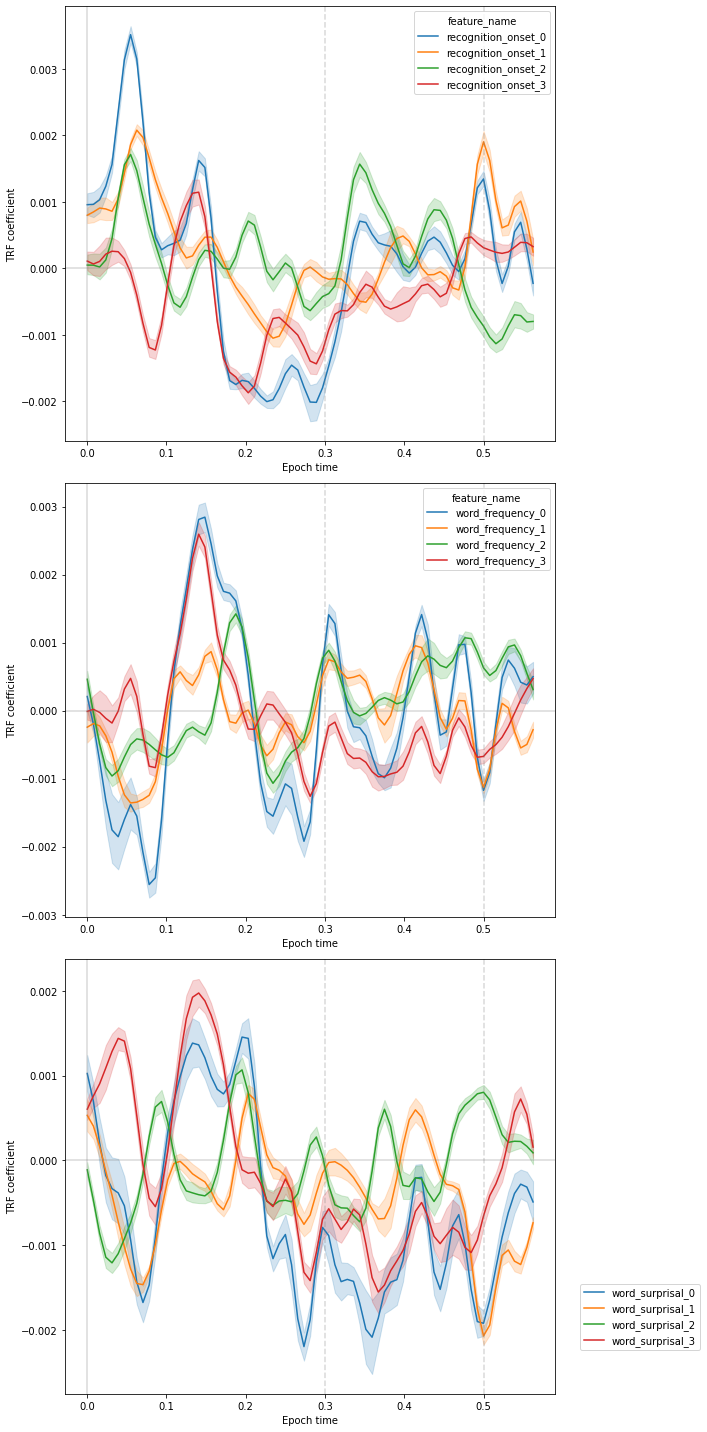

In [44]:
f, axs = plt.subplots(len(sample_ds.variable_feature_names), figsize=(10, 20))

for i, (ax, feature_name) in enumerate(zip(axs, sample_ds.variable_feature_names)):
    plot_trf_coefficients(coef_df, feature_match_patterns=[f"{feature_name}_\d"], ax=ax)

In [51]:
variable_df = coef_df[coef_df.feature_name.str.match("|".join(sample_ds.variable_feature_names))].copy()
variable_df["quantile"] = variable_df.feature_name.str.extract(r"_(\d+)").astype(int)
variable_df["base_feature"] = variable_df.feature_name.str.extract(r"^(.+)_\d$")
variable_df

,feature,lag,sensor,coef,epoch_time,feature_name,fold,name,quantile,base_feature
4380,20,0,0,0.001728,0.000000,recognition_onset_0,0,microaverage,0,recognition_onset
4381,20,0,1,0.001194,0.000000,recognition_onset_0,0,microaverage,0,recognition_onset
4382,20,0,2,0.000905,0.000000,recognition_onset_0,0,microaverage,0,recognition_onset
4383,20,1,0,0.001740,0.007812,recognition_onset_0,0,microaverage,0,recognition_onset
4384,20,1,1,0.001062,0.007812,recognition_onset_0,0,microaverage,0,recognition_onset
...,...,...,...,...,...,...,...,...,...,...
56059,31,71,1,0.000950,0.554688,word_surprisal_3,7,microaverage,3,word_surprisal
56060,31,71,2,0.001112,0.554688,word_surprisal_3,7,microaverage,3,word_surprisal
56061,31,72,0,0.000370,0.562500,word_surprisal_3,7,microaverage,3,word_surprisal
56062,31,72,1,0.000287,0.562500,word_surprisal_3,7,microaverage,3,word_surprisal


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


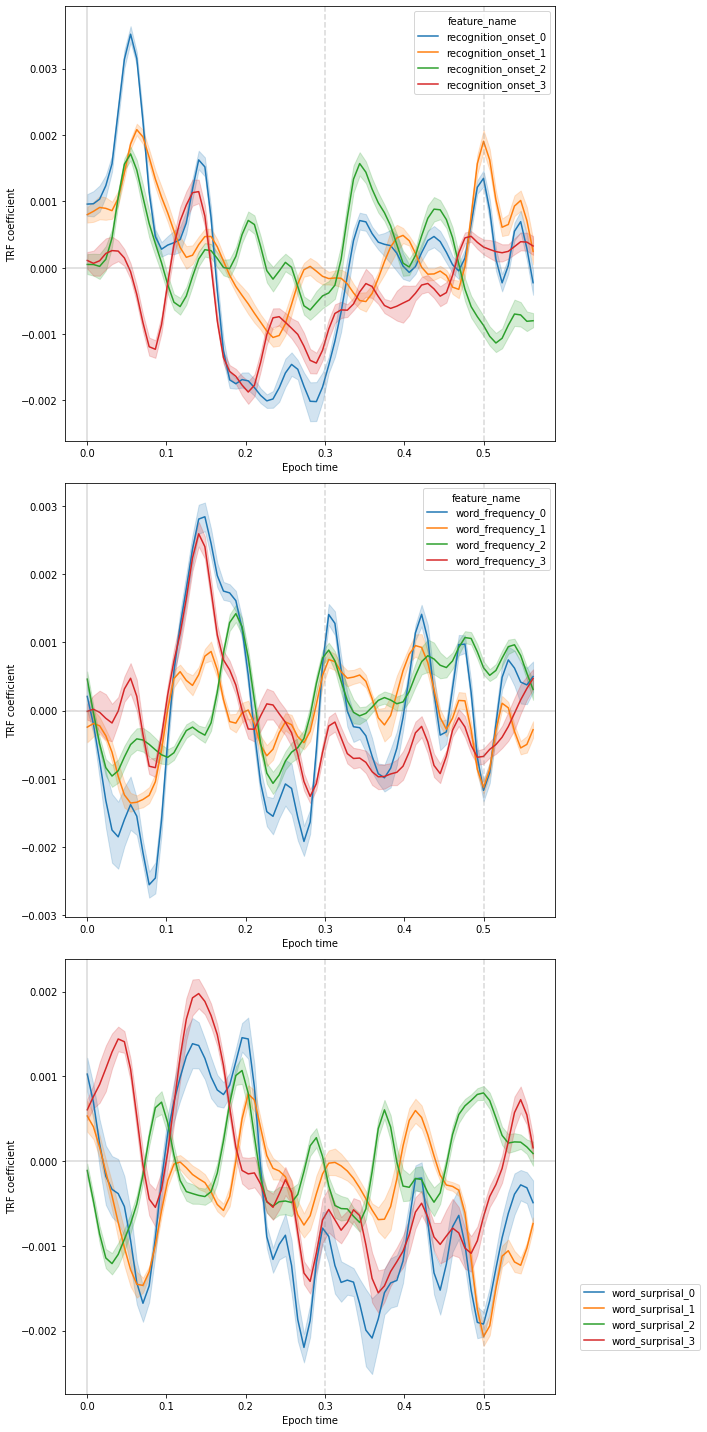

In [54]:
f, axs = plt.subplots(len(sample_ds.variable_feature_names), figsize=(10, 20))
for ax, (feature_name, rows) in zip(axs, variable_df.groupby("base_feature")):
    plot_trf_coefficients(rows, ax=ax)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


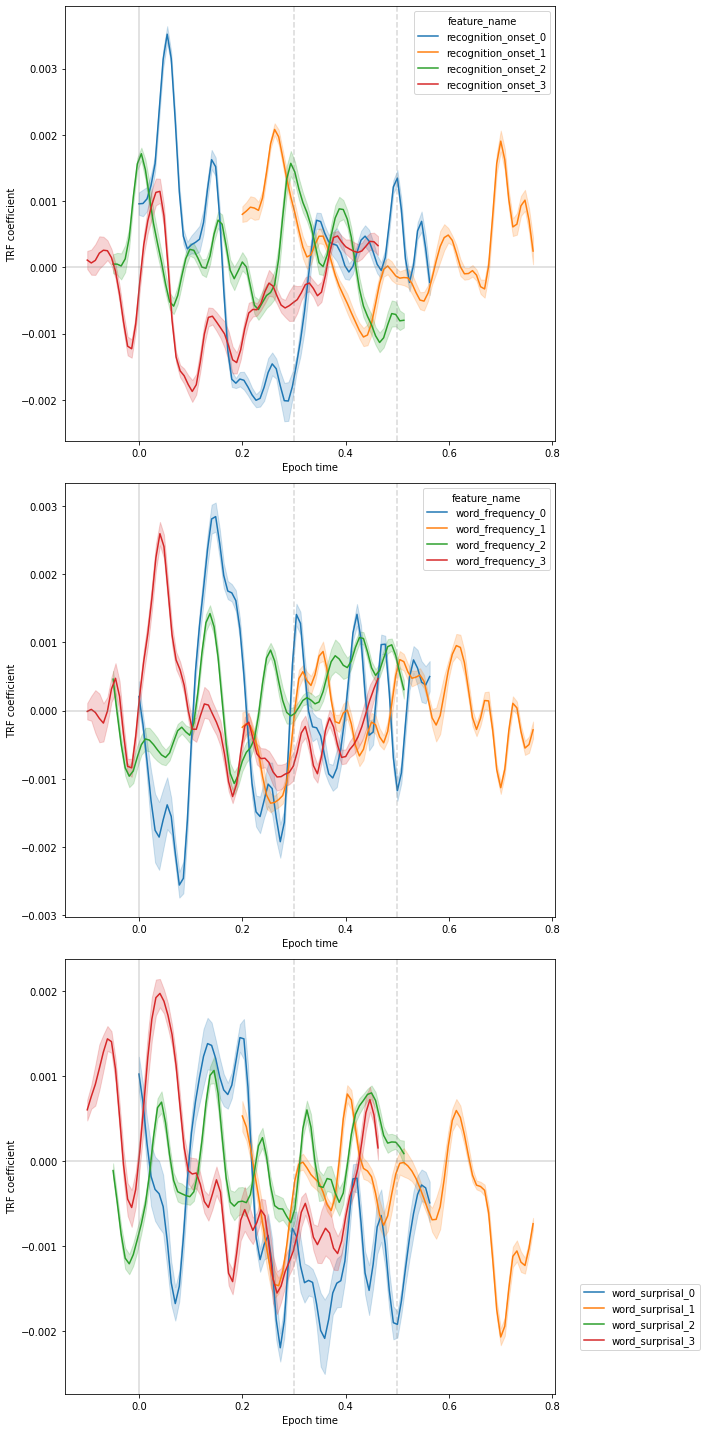

In [67]:
quantile_shifts = pd.Series({0: 0.0, 1: -0.2, 2: 0.05, 3: 0.1}, name="quantile_shift")
quantile_shifts

variable_df_shifted = pd.merge(variable_df, quantile_shifts, left_on="quantile", right_index=True)
variable_df_shifted["epoch_time"] -= variable_df_shifted.quantile_shift

f, axs = plt.subplots(len(sample_ds.variable_feature_names), figsize=(10, 20))
for ax, (feature_name, rows) in zip(axs, variable_df_shifted.groupby("base_feature")):
    plot_trf_coefficients(rows, ax=ax)